# Pandas 2 (Data Analysis Example)

This lecture will do an example analysis of a reasonably large dataset.

Our data is from [NYC Open data](https://nycopendata.socrata.com/) (over 1200+ datasets available!) It contains all 311 complaints from November 1, 2014 until January 6, 2015. This lecture is adapted from [here](https://www.wakari.io/sharing/bundle/jvns/PyData%20NYC%202013%20tutorial).

The data is in the file: 311_calls_2months.csv

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
orig_data = pd.read_csv('311_calls_2months.csv',
                        nrows=100000,
                        dtype=str, #automatically identifying proper data types usually takes lots of time
                        parse_dates=['Created Date'])

In [3]:
print(orig_data.columns.values)

['Unique Key' 'Created Date' 'Closed Date' 'Agency' 'Agency Name'
 'Complaint Type' 'Descriptor' 'Location Type' 'Incident Zip'
 'Incident Address' 'Street Name' 'Cross Street 1' 'Cross Street 2'
 'Intersection Street 1' 'Intersection Street 2' 'Address Type' 'City'
 'Landmark' 'Facility Type' 'Status' 'Due Date'
 'Resolution Action Updated Date' 'Community Board' 'Borough'
 'X Coordinate (State Plane)' 'Y Coordinate (State Plane)'
 'Park Facility Name' 'Park Borough' 'School Name' 'School Number'
 'School Region' 'School Code' 'School Phone Number' 'School Address'
 'School City' 'School State' 'School Zip' 'School Not Found'
 'School or Citywide Complaint' 'Vehicle Type' 'Taxi Company Borough'
 'Taxi Pick Up Location' 'Bridge Highway Name' 'Bridge Highway Direction'
 'Road Ramp' 'Bridge Highway Segment' 'Garage Lot Name' 'Ferry Direction'
 'Ferry Terminal Name' 'Latitude' 'Longitude' 'Location']


In [4]:
orig_data.iloc[0]

Unique Key                                      29641524
Created Date                         2015-01-06 02:14:39
Closed Date                                          NaN
Agency                                             CHALL
Agency Name                                        CHALL
Complaint Type                     Opinion for the Mayor
Descriptor                                  PUBLICSAFETY
Location Type                                        NaN
Incident Zip                                         NaN
Incident Address                                     NaN
Street Name                                          NaN
Cross Street 1                                       NaN
Cross Street 2                                       NaN
Intersection Street 1                                NaN
Intersection Street 2                                NaN
Address Type                                         NaN
City                                                 NaN
Landmark                       

## What do folks complain about?

In [5]:
# Complaint Type looks interesting
orig_data['Complaint Type']

0          Opinion for the Mayor
1             Noise - Commercial
2                   Animal Abuse
3          Street Sign - Missing
4        Noise - Street/Sidewalk
                  ...           
99995             HEAT/HOT WATER
99996             HEAT/HOT WATER
99997             HEAT/HOT WATER
99998             HEAT/HOT WATER
99999              PAINT/PLASTER
Name: Complaint Type, Length: 100000, dtype: object

## What do they complain about the most?

In [6]:
# Let us aggregate all the complaints and see the frequency of each complaint type
vc = orig_data['Complaint Type'].value_counts()
vc[:10]

HEAT/HOT WATER            20286
Blocked Driveway           5760
Street Light Condition     5288
Street Condition           4495
Illegal Parking            4045
UNSANITARY CONDITION       3855
PAINT/PLASTER              3384
PLUMBING                   2846
Noise - Commercial         2542
Opinion for the Mayor      2373
Name: Complaint Type, dtype: int64

It's November, and New Yorkers really want their HOT WATER flowing.


## ... and the least?

In [7]:
vc[-10:]

Legal Services Provider Complaint    1
Invitation                           1
Highway Sign - Missing               1
Lifeguard                            1
Transportation Provider Complaint    1
Squeegee                             1
Tanning                              1
Standpipe - Mechanical               1
Public Assembly                      1
Illegal Fireworks                    1
Name: Complaint Type, dtype: int64

It is often easier to plot things. Though we will look at plotting in detail in a later lecture, we can get started now.

<AxesSubplot:>

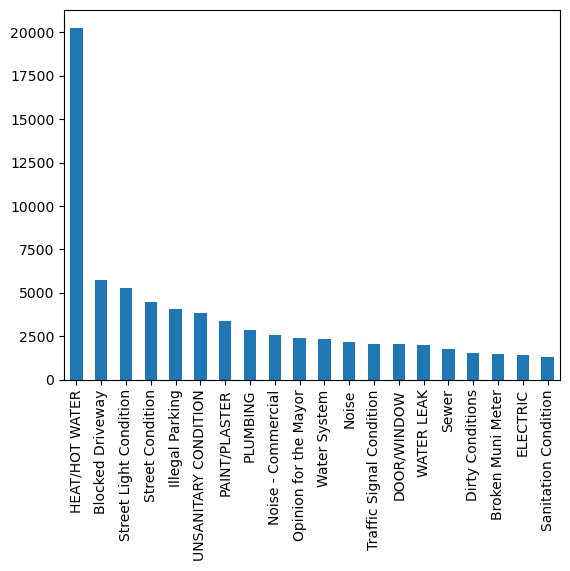

In [8]:
# Plot a histogram of the top-20 complaints.
top_20_vc = vc[:20]
top_20_vc.plot(kind='bar') #indices become x values, values become y values

What if we want the y-axis to show the fraction of complaints, instead of the number of complaints?

We must **normalize** the value counts (vc) by the total number of complaints.

<AxesSubplot:>

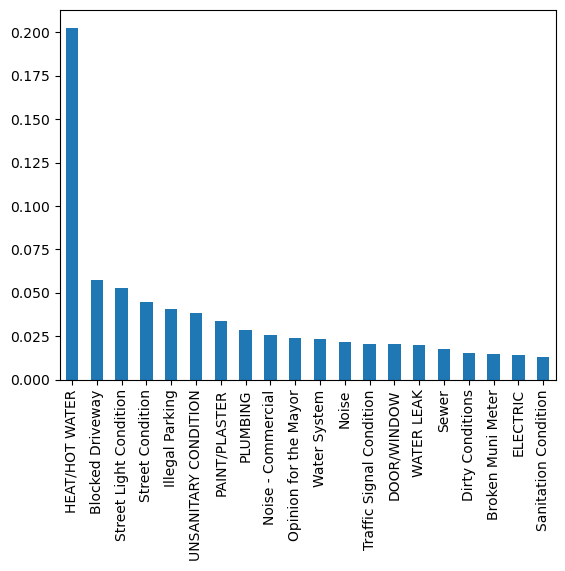

In [9]:
top_20_vc_fraction = top_20_vc / vc.sum() # or divide by len(df) as long as complaint type isn't missing in any rows
top_20_vc_fraction.plot(kind='bar')

## Which locations complain the most?

We have the incident zipcode, and we have the borough. Let's look at these.

In [10]:
orig_data['Borough'][:10]

0    Unspecified
1         QUEENS
2         QUEENS
3       BROOKLYN
4      MANHATTAN
5         QUEENS
6    Unspecified
7       BROOKLYN
8      MANHATTAN
9    Unspecified
Name: Borough, dtype: object

How do we plot the number of complaints for each Borough?

<AxesSubplot:>

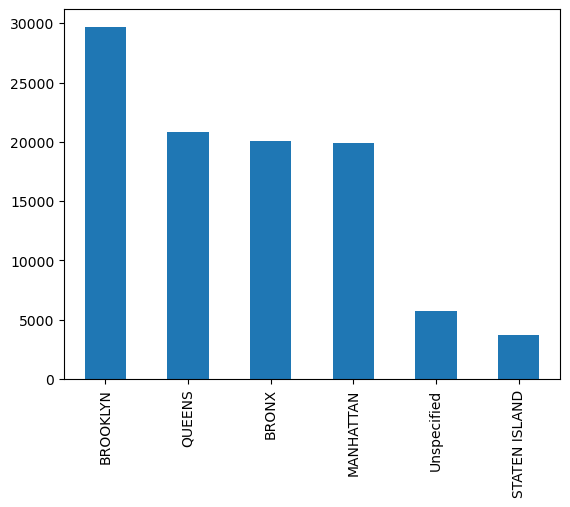

In [11]:
orig_data['Borough'].value_counts().plot(kind='bar')

We are getting "Unspecified", but that's really a missing value. We should set missing values to NaN so that they are not counted.

<AxesSubplot:>

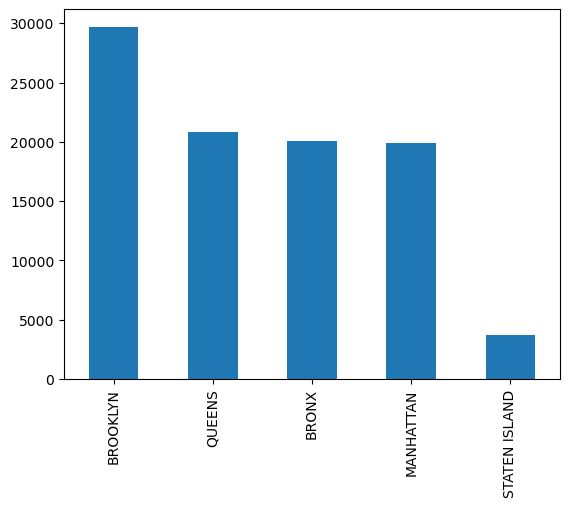

In [12]:
mask = (orig_data['Borough'] == 'Unspecified')
orig_data.loc[mask, 'Borough'] = np.nan # This sets the value to NaN

# Let's redo the bar plot
orig_data['Borough'].value_counts().plot(kind='bar')

Let's do the same by zipcode.

In [13]:
orig_data['Incident Zip'][:5]

0      NaN
1    11372
2    11416
3    11233
4    10022
Name: Incident Zip, dtype: object

<AxesSubplot:>

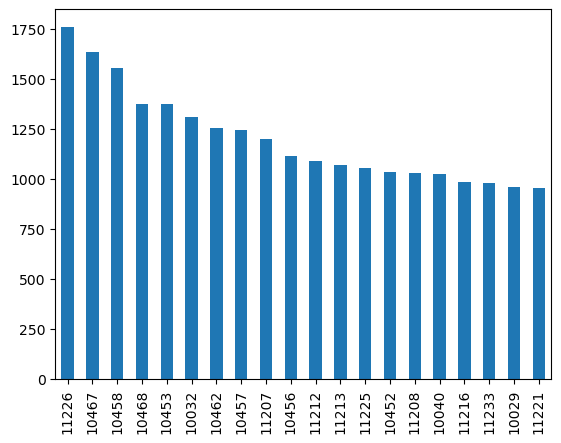

In [14]:
# Number of complaints by zipcode
orig_data['Incident Zip'].value_counts()[:20].plot(kind='bar')

## Find the Borough for each zip-code

Let's do something a bit more complex. We have the top zip-codes, but that gives little understanding. Let us find the Borough for each zipcode.

How do we do this?

We want to create a **Series** of Borough indexed by zipcode.
In this Series, we must have:

* for each zipcode, there should be one borough, and
* there should be no duplicate zipcodes in the index.

In [15]:
borough_zip = orig_data[['Borough', 'Incident Zip']]
borough_zip[:5]

,Borough,Incident Zip
0,NaN,NaN
1,QUEENS,11372
2,QUEENS,11416
3,BROOKLYN,11233
4,MANHATTAN,10022


Trouble: both have missing values, and we must get rid of these.

In [16]:
# Detect missing boroughs
mask_borough = borough_zip['Borough'].notnull()
mask_borough[:5]

0    False
1     True
2     True
3     True
4     True
Name: Borough, dtype: bool

In [17]:
# Similarly, we get a mask for the non-null zipcodes
mask_zip = borough_zip['Incident Zip'].notnull()

Which are the rows we want to keep?

In [18]:
# We combine the two masks
mask = (mask_borough & mask_zip)  # mask is True only if both mask_borough and mask_zip are True

In [19]:
# Apply the mask
borough_zip_clean = borough_zip[mask]
borough_zip_clean[:5]

,Borough,Incident Zip
1,QUEENS,11372
2,QUEENS,11416
3,BROOKLYN,11233
4,MANHATTAN,10022
5,QUEENS,11368


Another option is to use **dropna()**

In [20]:
borough_zip_clean = borough_zip.dropna(how='any')
borough_zip_clean[:5]

,Borough,Incident Zip
1,QUEENS,11372
2,QUEENS,11416
3,BROOKLYN,11233
4,MANHATTAN,10022
5,QUEENS,11368


We have a DataFrame of Borough and zipcode with no missing values. However this has two problems:

* The (Borough, Incident Zip) pairs could be repeated multiple times.
* Some zipcodes could span multiple Boroughs (!)

We need to get rid of these **duplicates**.

We will use `df.drop_duplicates(subset='Incident Zip')`

### Digression on drop_duplicates
Suppose my DataFrame df was the following

| Borough | Zip|
|---|---|
|Manhattan | 10000 |
|Queens | 12345 |
|Queens | 10000 |
| Queens | 12345 |

* Zipcode=10000 is split between Manhattan and Queens.
* (Queens, 12345) is repeated

### What happens if we run `df.drop_duplicates()`?
* It iterates over rows, dropping rows only if we have seen **the entire row** before.

| Borough | Zip| |
|---|---| |
|Manhattan | 10000 | Keep |
|Queens | 12345 | Keep |
|Queens | 10000 | Keep |
| Queens | 12345 | **DROP** |

### What if we run `df.drop_duplicates(subset='Zip')`?
* It iterates over rows, dropping rows only if we have seen **this Zipcode** before (NOT the entire row)

| Borough | Zip| |
|---|---| |
|Manhattan | 10000 | Keep |
|Queens | 12345 | Keep |
|Queens | 10000 | **DROP** |
| Queens | 12345 | **DROP** |

In general you can do
<pre>
df.drop_duplicates(subset=[...list of columns...])
</pre>

Then, it will use all of those columns to determine duplicates.

### End of digression

`DataFrame.drop_duplicates(subset='Incident Zip')`

* This means we want Pandas to use only the zip-code while determining duplicates
* instead of both Borough and zip-code

* For any zip-code, only one **(Borough, Incident Zip)** row will be retained

In [21]:
borough_zip_dedup = borough_zip_clean.drop_duplicates(subset='Incident Zip')

print("Initial length of DataFrame =", len(borough_zip_clean))
print("After removing duplicates, length =", len(borough_zip_dedup))

Initial length of DataFrame = 87629
After removing duplicates, length = 196


> DataFrame.drop_duplicates()

* By default, it removes duplicate rows
* So if **(Queens, 11372)** is repeated multiple times, only one such row remains.

> DataFrame.drop_duplicates(subset='Incident Zip')

* This means we want Pandas to use only the zip-code while determining duplicates
* instead of both Borough and zip-code

* For any zip-code, only one **(Borough, Incident Zip)** row will be retained

We now have a good DataFrame of unique (Zipcodes, Borough) pairs.

In [22]:
borough_zip_dedup[:5]

,Borough,Incident Zip
1,QUEENS,11372
2,QUEENS,11416
3,BROOKLYN,11233
4,MANHATTAN,10022
5,QUEENS,11368


However, we need to create a **Series** with the zipcode as index.

In [23]:
tmp_df = borough_zip_dedup.set_index('Incident Zip')
tmp_df[:5]

,Borough
Incident Zip,
11372,QUEENS
11416,QUEENS
11233,BROOKLYN
10022,MANHATTAN
11368,QUEENS


In [24]:
# Recall that each column of a DataFrame is a Series.
borough_zip_series = tmp_df['Borough']
borough_zip_series[:5]

Incident Zip
11372       QUEENS
11416       QUEENS
11233     BROOKLYN
10022    MANHATTAN
11368       QUEENS
Name: Borough, dtype: object

### Summary (find the Borough for each zip-code)

We wanted to get a Series of Boroughs, indexed by Zipcode.

* We selected zipcodes and boroughs from the full data

> borough_zip = orig_data[['Borough', 'Incident Zip']]

* We removed missing values by applying a mask.
    * there is also a dropna() method which does what we did

* We removed duplicates
    * drop_duplicates() method

* We set the zipcode to be the index
    * set_index() method

* Finally, we selected the 'Borough' Series, now indexed by zipcode.

## Plot the most _interesting_ zip-codes

Let us again plot the number of incidents by zip-code, but with the zip-code labels replaced by the corresponding Boroughs.

How do we do this?

1. Get the number of complaints by zipcode. This gives a Series, indexed by zipcode.
2. Get a Series of Boroughs, again indexed by zipcode.
3. **Rename** the index of the first series using the Series of Step 2.

**Step 1:** Get the number of complaints by zipcode.

In [25]:
# Step 1: Get the number of complaints by zipcode.
vc = orig_data['Incident Zip'].value_counts()
vc[:5]

11226    1758
10467    1632
10458    1554
10468    1373
10453    1372
Name: Incident Zip, dtype: int64

**Step 2:** Get a Series of Boroughs, indexed by zipcode.

In [26]:
borough_zip_series[:5]

Incident Zip
11372       QUEENS
11416       QUEENS
11233     BROOKLYN
10022    MANHATTAN
11368       QUEENS
Name: Borough, dtype: object

**Step 3:** Replace the index of the value-counts Series (vc) by the corresponding Borough from borough_zip_series.

In [27]:
# Step 3: Replace index of vc with borough_zip_series
vc_renamed = vc.rename(borough_zip_series)
vc_renamed[:5]

BROOKLYN    1758
BRONX       1632
BRONX       1554
BRONX       1373
BRONX       1372
Name: Incident Zip, dtype: int64

<AxesSubplot:>

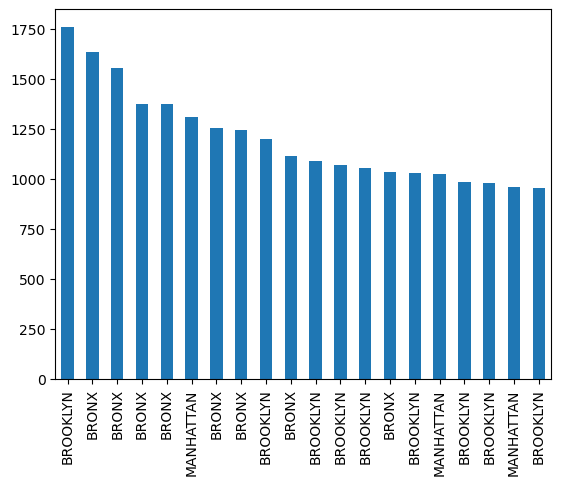

In [28]:
vc_renamed[:20].plot(kind='bar')

* **Surprise!** The top-complaining zipcodes seem to be mostly from the Bronx, but we'd earlier seen that Brooklyn complains the most?

<AxesSubplot:>

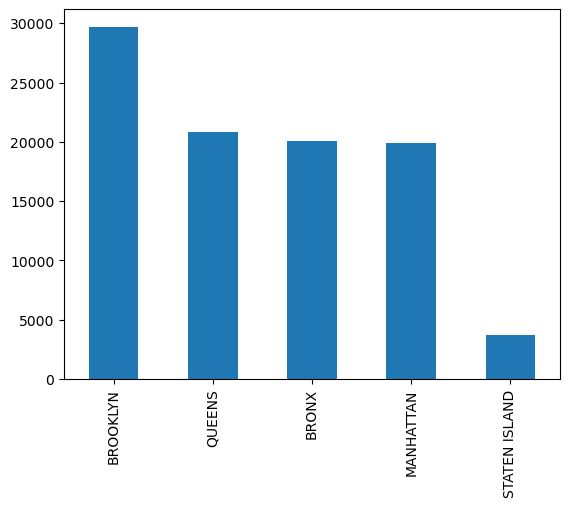

In [29]:
orig_data['Borough'].value_counts().plot(kind='bar')

**Why?** Maybe Brooklyn just has more zipcodes?

## Find the number of zipcodes for each Borough.

How would we solve this?

In [30]:
zip_per_borough = orig_data[['Borough', 'Incident Zip']].dropna(how='any') \
                                                        .drop_duplicates() \
                                                        ['Borough'] \
                                                        .value_counts()
zip_per_borough

QUEENS           65
MANHATTAN        58
BROOKLYN         40
BRONX            26
STATEN ISLAND    12
Name: Borough, dtype: int64

So, it isn't the case that Brooklyn has far more zipcodes than everyone else... Still, it has quite a few more than the Bronx.

## Plot complaints per zipcode for each Borough.

In [31]:
# We have the borough, zipcode DataFrame with null values removed.
# Each row corresponds to one complaint.
borough_zip_clean[:5]

,Borough,Incident Zip
1,QUEENS,11372
2,QUEENS,11416
3,BROOKLYN,11233
4,MANHATTAN,10022
5,QUEENS,11368


In [32]:
# Get the number of complaints by borough
borough_counts = borough_zip_clean['Borough'].value_counts()
borough_counts

BROOKLYN         27748
QUEENS           19159
BRONX            18884
MANHATTAN        18523
STATEN ISLAND     3315
Name: Borough, dtype: int64

<AxesSubplot:>

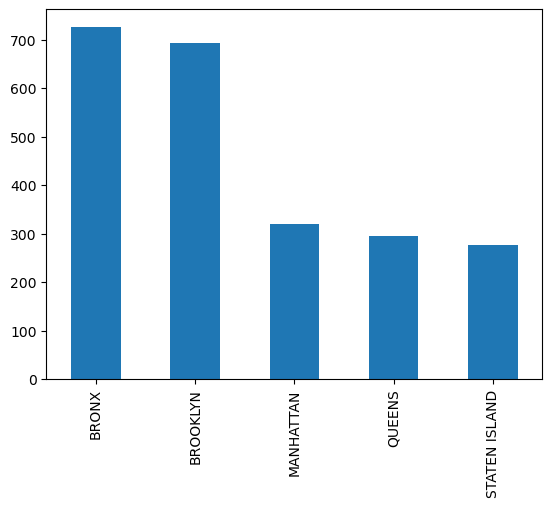

In [33]:
# Divide this by zip_per_borough, and plot.
borough_counts_per_zip = borough_counts / zip_per_borough
borough_counts_per_zip.plot(kind='bar')

**The Bronx claims the throne!**

## I'm going to NYC and I hate noise. Which streets should I avoid?

Let us now focus on one particular kind of complaint: Noise complaints.
How do we find all types of noise-related complaints?

In [34]:
orig_data['Complaint Type'].unique()  # Get all types of complaints

array(['Opinion for the Mayor', 'Noise - Commercial', 'Animal Abuse',
       'Street Sign - Missing', 'Noise - Street/Sidewalk',
       'Illegal Parking', 'Consumer Complaint', 'Blocked Driveway',
       'Food Establishment', 'Street Condition', 'Graffiti', 'Rodent',
       'Noise - Helicopter', 'Homeless Person Assistance', 'Complaint',
       'Street Light Condition', 'Noise - Vehicle',
       'Overgrown Tree/Branches', 'Traffic Signal Condition',
       'Found Property', 'Benefit Card Replacement', 'PLUMBING',
       'HEAT/HOT WATER', 'UNSANITARY CONDITION', 'PAINT/PLASTER',
       'WATER LEAK', 'FLOORING/STAIRS', 'Sewer', 'Water System', 'Noise',
       'Request for Information', 'Dirty Conditions',
       'DCA / DOH New License Application Request', 'Highway Condition',
       'SCRIE', 'Missed Collection (All Materials)', 'Snow',
       'Agency Issues', 'Non-Residential Heat', 'Vending',
       'Derelict Vehicle', 'Other Enforcement', 'Litter Basket / Request',
       'Derelict Ve

How do we find the noisiest streets?

1. Create a function that checks if the complaint type contains 'Noise'
    * How?
2. Select all noise-related complaints
    * Build a mask using the function of Step 1
3. Pick the streets that occur most frequently
    * value_counts()

**Step 1:** Create a function that checks if the complaint type contains 'Noise'.

In [35]:
# Side note: Pandas actually has functions to do regular expressions easily,
#           but we won't get into that here.
import re
def noisy(s):
    """Given a Complaint Type string, return True if it is
       a noise-related complaint."""
    return (len(re.findall('[nN]oise', s)) > 0)

# Test
print(noisy('Noise - Commercial'))
print(noisy('ELEVATOR'))

True
False


**Step 2:** Build a mask using this function.

In [36]:
noise_mask = orig_data['Complaint Type'].map(noisy)

We have the mask that is True if the Complaint is noise-related; now we select those rows.

In [37]:
noise_complaints = orig_data[noise_mask]
noise_complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
1,29636054,2015-01-06 02:09:30,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11372,70-06 ROOSEVELT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.74642854264474,-73.89533997952648,"(40.74642854264474, -73.89533997952648)"
4,29641040,2015-01-06 02:03:11,01/06/2015 02:36:38 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,10022,238 EAST 58 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.76049674396275,-73.96604690111288,"(40.76049674396275, -73.96604690111288)"
20,29639511,2015-01-06 01:32:51,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11372,70-06 ROOSEVELT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.74642854264474,-73.89533997952648,"(40.74642854264474, -73.89533997952648)"
24,29641827,2015-01-06 01:27:24,NaN,EDC,Economic Development Corporation,Noise - Helicopter,Other,Above Address,10040,89 THAYER STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.864212983761796,-73.92753738525039,"(40.864212983761796, -73.92753738525039)"
27,29638620,2015-01-06 01:24:16,01/06/2015 02:19:00 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10011,355 WEST 16 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.74173312459783,-74.00308183921501,"(40.74173312459783, -74.00308183921501)"


**Step 3:** Pick the streets that occur most frequently.

<AxesSubplot:>

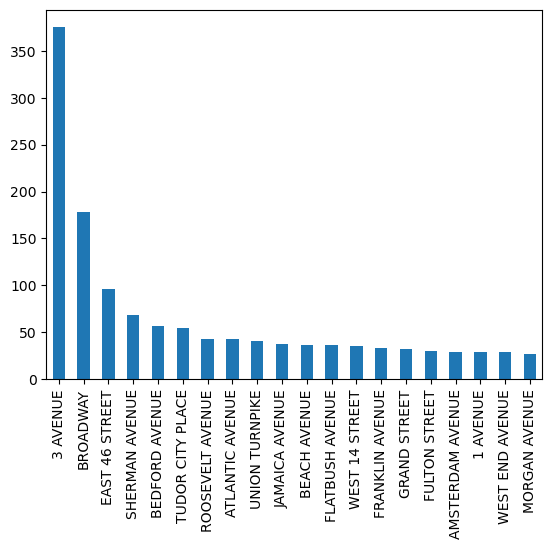

In [38]:
# Which streets have the most noise complaints?
noise_vc = noise_complaints['Street Name'].value_counts()
noise_vc[:20].plot(kind='bar')

Sweet.

No problems, right?

**Are we sure there's only one "3 AVENUE"?**

In [39]:
noise_complaints[noise_complaints['Street Name'] == '3 AVENUE']['Borough'].value_counts()

MANHATTAN    358
BROOKLYN      16
BRONX          1
Name: Borough, dtype: int64

There is a "3 AVENUE" in Manhattan, Brooklyn, and the Bronx. To find the noisy streets, we need to differentiate between these.

What do we do?

1. Create a new column 'Street & Borough', which will look like '3AVENUE (MANHATTAN)'
2. We will do value_counts() on this 'Street & Borough' column.

In [40]:
# Step 1: Create the new column
noise_complaints_copy = noise_complaints.copy()
noise_complaints_copy['Street & Borough'] = noise_complaints['Street Name'] + \
                                            ' (' + noise_complaints['Borough'] + ')'
noise_complaints_copy['Street & Borough'][:5]

1      ROOSEVELT AVENUE (QUEENS)
4     EAST 58 STREET (MANHATTAN)
20     ROOSEVELT AVENUE (QUEENS)
24     THAYER STREET (MANHATTAN)
27    WEST 16 STREET (MANHATTAN)
Name: Street & Borough, dtype: object

<AxesSubplot:>

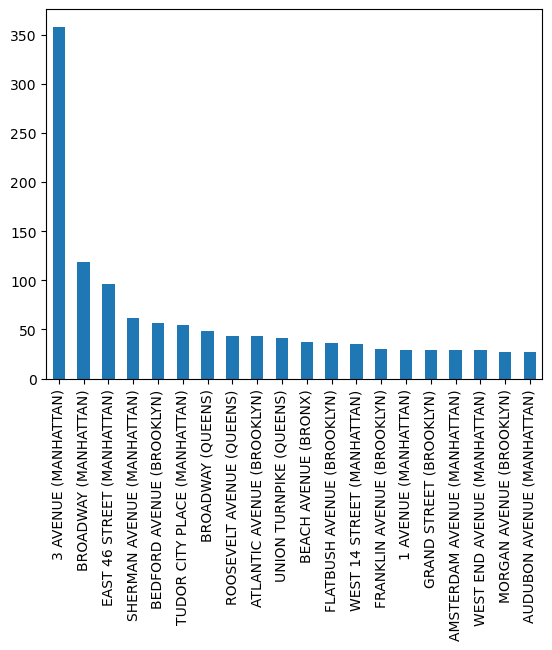

In [41]:
# Now we can do value_counts
noise_complaints_copy['Street & Borough'].value_counts()[:20].plot(kind='bar')

**Avoid noisy Manhattan streets!**

## Summary

We saw several common use cases:

* Find the most common or most uncommon items in a Series
    * _value\_counts()_
* Deal with missing data
    * _dropna()_
    * or just create masks with _isnull()_ and _notnull()_
* Deal with duplicates
    * *drop_duplicates()*
* Operate on rows rather than columns
    * _DataFrame.T_  
    * (stands for *transpose*)
* Plotting
    * _plot(kind="bar")_